# NLP Analysis of Student Course Evaluations for BI 1 and 2: Topic Modeling & Sentiment Analysis

This notebook presents a comprehensive Natural Language Processing (NLP) workflow for analyzing student course evaluations from two Business Intelligence courses. It covers data preprocessing, topic modeling using Latent Dirichlet Allocation (LDA), sentiment analysis, leading to interactive prediction via a Streamlit interface. The analysis identifies key themes in student feedback, quantifies sentiment distribution, and provides actionable recommendations for course improvement. All models and vectorizers are exported for reproducibility and deployment.

## Step 1: Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import streamlit as st

%matplotlib inline

## Step 2: Load and Preview the Dataset


In [14]:
df = pd.read_csv('202511-ft_bi1_bi2_course_evaluation.csv')
print(df.columns)
df.head()

Index(['timestamp', 'consent', 'a_1_student_id', 'a_2_gender',
       'a_3_class_group', 'b_1_i_enjoyed_the_course',
       'b_2_classes_started_and_ended_on_time',
       'b_3_participative_learning_environment',
       'b_4_subject_content_delivered_according_to_course_outline_and_my_expectations',
       'b_5_topics_were_clear_and_logically_developed',
       'b_6_developed_my_oral_and_writing_skills',
       'b_7_developed_my_reflective_and_critical_reasoning_skills',
       'b_8_the_assessment_methods_assisted_me_to_learn',
       'b_9_received_relevant_feedback',
       'b_10_read_recommended_readings_and_notes',
       'b_11_used_the_elearning_material_posted',
       'c_1_principles_of_business_intelligence_and_the_dataops_philosophy',
       'c_2_data_engineering_and_data_analytics',
       'c_3_dashboarding_for_business-facing_and_customer-facing_analytics',
       'c_4_regression_and_classification',
       'c_5_clustering_and_association_rule_mining',
       'c_6_serving_ml

,timestamp,consent,a_1_student_id,a_2_gender,a_3_class_group,b_1_i_enjoyed_the_course,b_2_classes_started_and_ended_on_time,b_3_participative_learning_environment,b_4_subject_content_delivered_according_to_course_outline_and_my_expectations,b_5_topics_were_clear_and_logically_developed,...,f_1_In_your_opinion_which_topics_(if_any)_should_be_added_to_the_Business_Intelligence_I_and_II_curriculum,f_2_In_your_opinion_which_topics_(if_any)_should_be_removed_from_the_Business_Intelligence_I_and_II_curriculum,f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course,f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes),average_course_evaluation_rating,sentiment,average_level_of_learning_attained_rating,average_level_of_skills_and_competencies_rating,average_pedagogical_strategy_effectiveness_rating,absenteeism_percentage
0,06-11-25 8:19,I CONSENT to my feedback being analyzed and us...,1,Male,Group A,5,5,5,5,5,...,NaN,NaN,The teacher was engaging,More group time to work on group activities,4.9091,positive,4.000,1.6923,4.0833,40.91
1,06-11-25 8:20,I CONSENT to my feedback being analyzed and us...,2,Male,Group A,5,5,5,5,5,...,Nothing,NaN,Teaching was on time,More quizes,5.0000,positive,5.000,4.0000,4.0000,9.09
2,06-11-25 8:21,I CONSENT to my feedback being analyzed and us...,3,Male,Group A,3,4,3,4,4,...,NaN,NaN,Well detailed notes\nWell explained concepts,More clear instructions given out during the l...,3.4545,negative,3.000,3.0000,3.5833,13.64
3,06-11-25 8:21,I CONSENT to my feedback being analyzed and us...,4,Male,Group A,4,4,4,4,4,...,NaN,NaN,The Lab works and Quizes,More engaging lessons,3.6364,negative,4.375,4.6154,4.3333,13.64
4,06-11-25 8:23,I CONSENT to my feedback being analyzed and us...,5,Male,Group A,5,5,5,5,5,...,NaN,NaN,Interactive teaching and use of analogies,Everything's seemingly fine,4.6364,positive,4.250,2.1538,2.7500,18.18


## Step 3: Preprocess the Text Data


In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Combine relevant free-text columns for analysis
text_columns = [
    'f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course',
    'f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes)'
]

def combine_text(row):
    return ' '.join([str(row[col]) for col in text_columns if col in row and pd.notnull(row[col])])

df['combined_text'] = df.apply(combine_text, axis=1)

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)  # Remove non-alphabetic characters, replace with space
    text = re.sub(r'\s+', ' ', text).strip()  # Collapse multiple spaces, strip leading/trailing spaces
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['combined_text'].apply(preprocess)
df[['combined_text', 'clean_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,combined_text,clean_text
0,The teacher was engaging More group time to wo...,teacher engaging group time work group activities
1,Teaching was on time More quizes,teaching time quizes
2,Well detailed notes\nWell explained concepts M...,well detailed notes well explained concepts cl...
3,The Lab works and Quizes More engaging lessons,lab works quizes engaging lessons
4,Interactive teaching and use of analogies Ever...,interactive teaching use analogies everything ...


## Step 4: Topic Modeling with LDA


### Document-Term Matrix (DTM): Justification and Approach

To prepare text data for topic modeling, we convert the cleaned text into a Document-Term Matrix (DTM) using `CountVectorizer`. Key parameter choices:

- **max_features=1000**: Limits the vocabulary to the 1000 most frequent words, reducing dimensionality and noise.
- **max_df=0.95**: Ignores words that appear in more than 95% of documents, as they are likely too common to be useful.
- **min_df=2**: Ignores words that appear in fewer than 2 documents, as they are too rare to be significant.
- **stop_words='english'**: Removes common English stopwords.

These choices help ensure the DTM is both efficient and interpretable, focusing the analysis on meaningful and frequent terms. This step is crucial for effective topic modeling and downstream analysis.

In [21]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components as needed
lda.fit(X)

def get_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx}: {', '.join(top_features)}")
    return topics

topics = get_topics(lda, vectorizer.get_feature_names_out())
for t in topics: print(t)

Topic 0: work, lab, group, unit, learning, liked, quizzes, works, module, labs
Topic 1: slides, labs, liked, concepts, practical, content, topics, better, notes, understanding
Topic 2: practical, real, content, understand, lecturer, business, knowledge, help, like, labs
Topic 3: labs, module, assignments, delivery, content, practical, classes, reflective, theory, lab
Topic 4: course, labs, class, helped, detailed, lab, work, understanding, lecturer, practical


### Visualizing Top Words per Topic

To better interpret the discovered topics, we visualize the top words for each topic using horizontal bar charts. This helps reveal the most important terms associated with each topic and supports human-in-the-loop labeling.

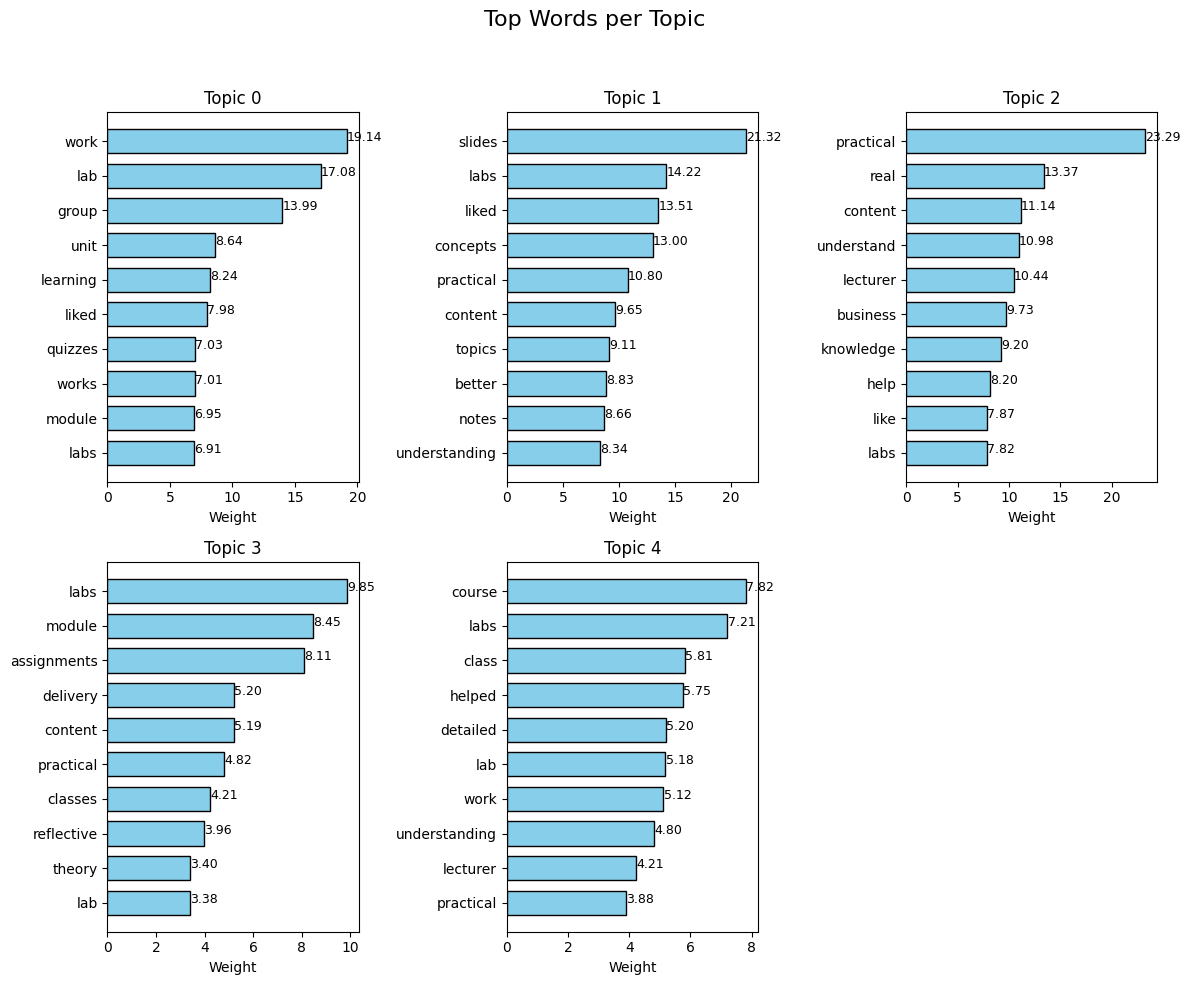

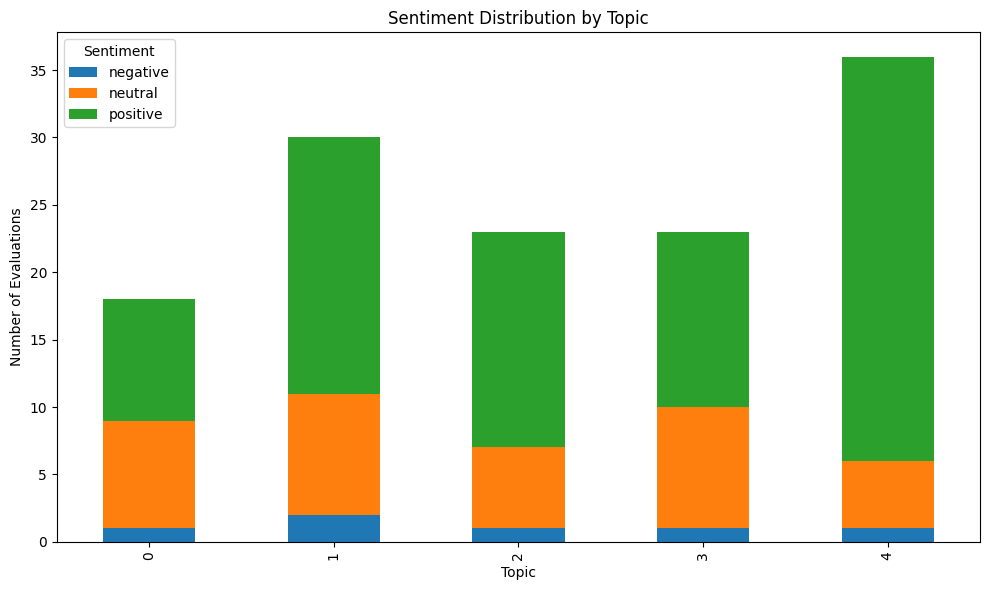

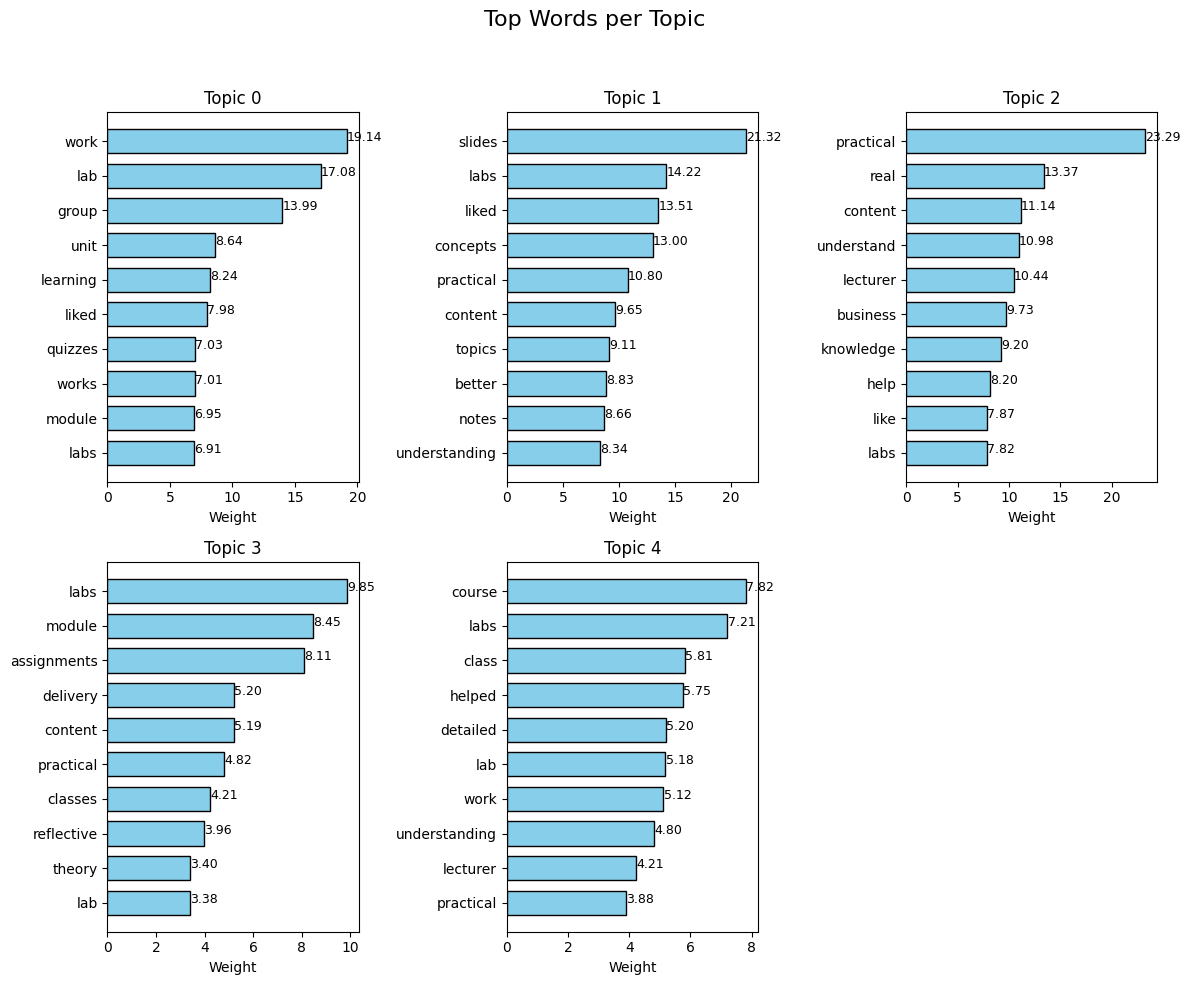

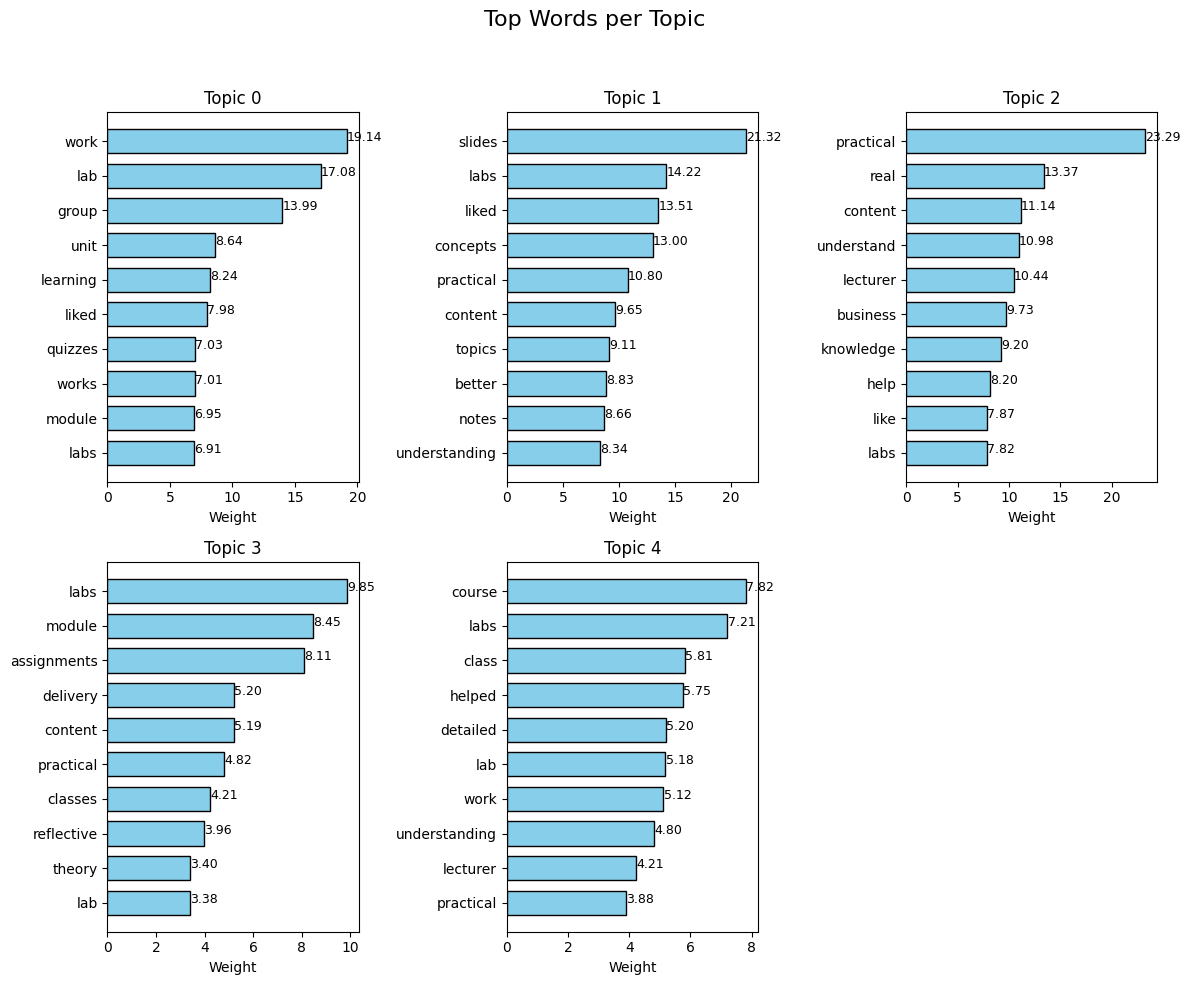

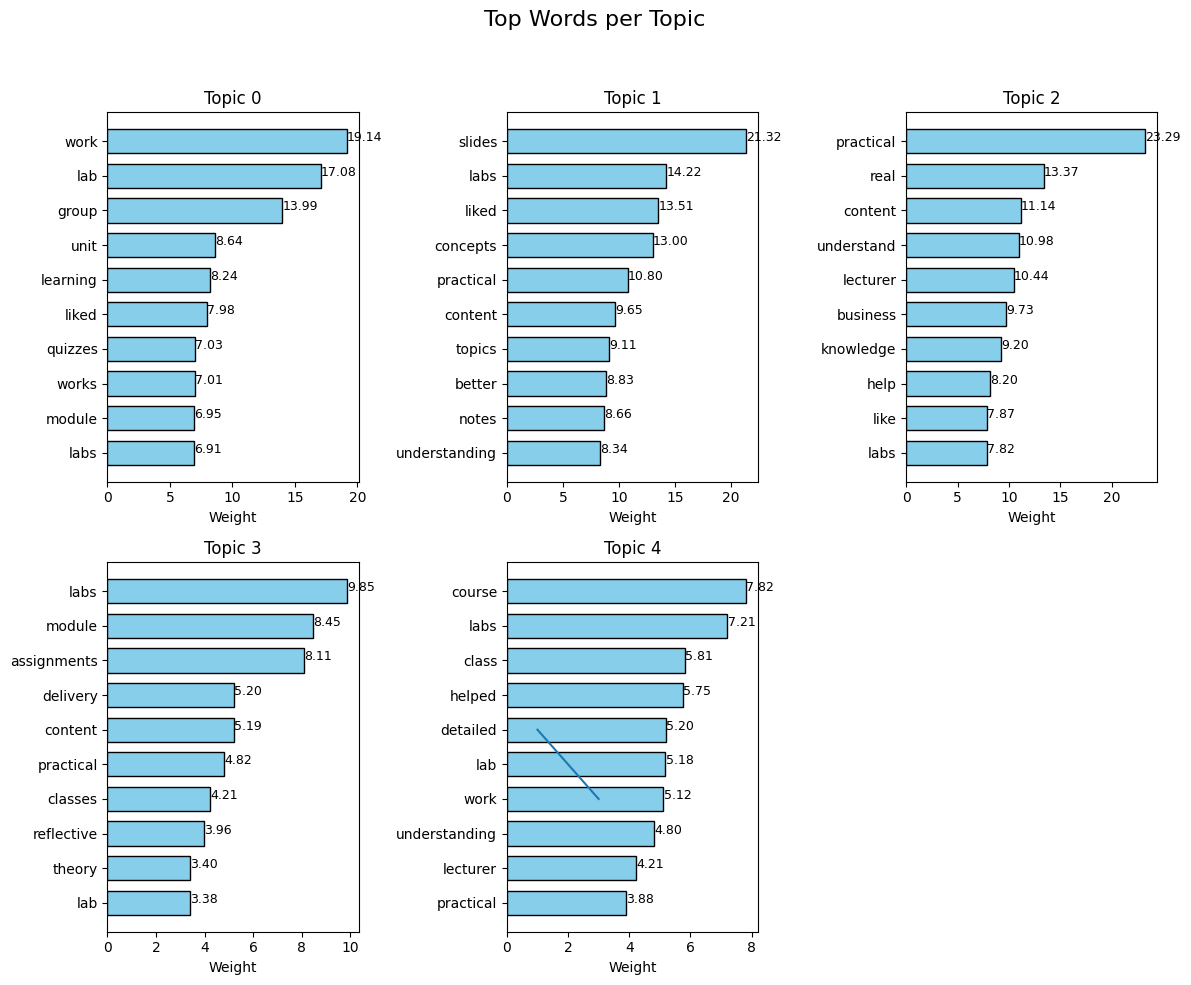

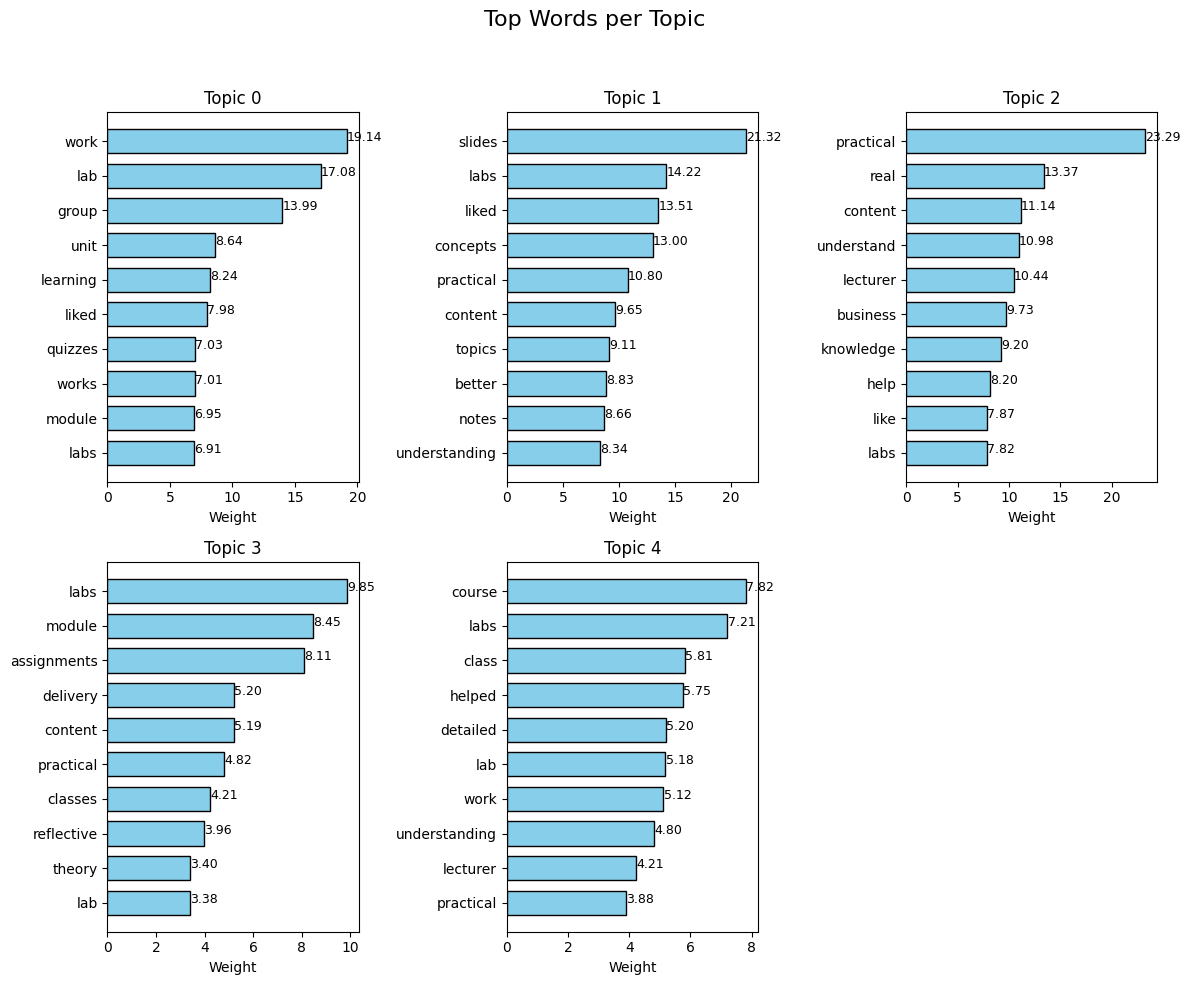

In [27]:
import math

def plot_topic_words(model, feature_names, n_words=10):
    n_topics = model.n_components
    n_cols = 3
    n_rows = math.ceil(n_topics / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for idx in range(n_topics):
        ax = axes[idx]
        topic = model.components_[idx]
        top_idx = topic.argsort()[:-n_words-1:-1]
        top_words = [feature_names[i] for i in top_idx]
        weights = topic[top_idx]

        y_pos = range(len(top_words))
        ax.barh(y_pos, weights, color='skyblue', height=0.7, edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_words)
        ax.invert_yaxis()
        ax.set_title(f"Topic {idx}", fontsize=12)
        ax.set_xlabel("Weight", fontsize=10)
        for i, v in enumerate(weights):
            ax.text(v + 0.01, i, f"{v:.2f}", color='black', fontsize=9)

    for j in range(n_topics, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Top Words per Topic", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # Instead of plt.show(), return the figure for notebook display
    return fig

fig = plot_topic_words(lda, vectorizer.get_feature_names_out())
fig

### Representative Reviews per Topic

To interpret and label topics, it's useful to examine sample reviews most strongly associated with each topic. This qualitative analysis provides context for the discovered topics and supports human-in-the-loop labeling.

In [28]:
def show_representative_reviews(df, topic_col='topic', text_col='combined_text', n_reviews=3):
    for topic_id in sorted(df[topic_col].unique()):
        topic_docs = df[df[topic_col] == topic_id]
        # If topic probability is available, sort by it; else, just take first n
        sample_reviews = topic_docs[text_col].head(n_reviews)
        print(f"\n{'='*60}")
        print(f"Representative Reviews for Topic {topic_id}")
        for i, review in enumerate(sample_reviews):
            print(f"Review #{i+1}:")
            print(review)
            print('-'*60)

show_representative_reviews(df)


Representative Reviews for Topic 0
Review #1:
It is involving and practical
Relevant in real life application
------------------------------------------------------------
Review #2:
Data science and Data analysis
------------------------------------------------------------
Review #3:
I liked the practical examples that were used to understand theory work
The lecturer clarified parts that were not easily understood at first Students should set clear concise goals at the beginning of the semester about what they expect to learn from the course.
------------------------------------------------------------

Representative Reviews for Topic 1
Review #1:
The teacher was engaging More group time to work on group activities
------------------------------------------------------------
Review #2:
relation of content with application to the real world. probably less group work, more individual tasks to push someone to further explore on a certain matter.
-----------------------------------------

### Human-in-the-Loop Topic Labeling

After reviewing the top words and representative reviews for each topic, we assign descriptive labels to each topic. This step improves interpretability and makes the results actionable for stakeholders.

In [29]:
# Example topic labels based on top words and sample reviews
topic_labels = {
    0: "Positive Course Experience and Engagement",
    1: "Suggestions for Improvement and Challenges",
    2: "Teaching Methods and Learning Activities",
    3: "Course Content and Structure",
    4: "Feedback and Assessment"
}

df['topic_label'] = df['topic'].map(topic_labels)

df[['topic', 'topic_label']].head()

,topic,topic_label
0,1,Suggestions for Improvement and Challenges
1,4,Feedback and Assessment
2,3,Course Content and Structure
3,2,Teaching Methods and Learning Activities
4,4,Feedback and Assessment


## Sentiment Analysis and Modeling
In this section, we build a sentiment analysis model using the cleaned text data. We will engineer features, train multiple classifiers, compare their performance, and select the best model for sentiment prediction.

In [30]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature engineering: TF-IDF with n-grams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf.fit_transform(df['clean_text'])
y = df['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Cross-validation
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_results = {}

for name, model in models.items():
    print(f"Cross-validating {name}...")
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
    results_df = pd.DataFrame({
        'Fold': range(1, len(scores['test_accuracy']) + 1),
        'Accuracy': scores['test_accuracy'],
        'Precision': scores['test_precision_weighted'],
        'Recall': scores['test_recall_weighted'],
        'F1-Score': scores['test_f1_weighted']
    })
    print(f"\n{name} - Raw Cross-Validation Metrics:")
    display(results_df)
    cv_results[name] = results_df

# Summarize results
summary = []
for name, df_cv in cv_results.items():
    summary.append({
        'Model': name,
        'Accuracy Mean': df_cv['Accuracy'].mean(),
        'Accuracy Std': df_cv['Accuracy'].std(),
        'Precision Mean': df_cv['Precision'].mean(),
        'Precision Std': df_cv['Precision'].std(),
        'Recall Mean': df_cv['Recall'].mean(),
        'Recall Std': df_cv['Recall'].std(),
        'F1-Score Mean': df_cv['F1-Score'].mean(),
        'F1-Score Std': df_cv['F1-Score'].std()
    })

results_df = pd.DataFrame(summary).sort_values('F1-Score Mean', ascending=False)
display(results_df)

Cross-validating Logistic Regression...


d:\New folder\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_


Logistic Regression - Raw Cross-Validation Metrics:


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Fold,Accuracy,Precision,Recall,F1-Score
0,1,0.692308,0.479290,0.692308,0.566434
1,2,0.692308,0.479290,0.692308,0.566434
2,3,0.692308,0.479290,0.692308,0.566434
3,4,0.692308,0.479290,0.692308,0.566434
4,5,0.692308,0.479290,0.692308,0.566434
5,6,0.692308,0.479290,0.692308,0.566434
6,7,0.692308,0.479290,0.692308,0.566434
7,8,0.615385,0.378698,0.615385,0.468864
8,9,0.615385,0.378698,0.615385,0.468864
9,10,0.615385,0.378698,0.615385,0.468864


d:\New folder\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

Cross-validating Naive Bayes...


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Naive Bayes - Raw Cross-Validation Metrics:


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Fold,Accuracy,Precision,Recall,F1-Score
0,1,0.692308,0.479290,0.692308,0.566434
1,2,0.692308,0.479290,0.692308,0.566434
2,3,0.692308,0.479290,0.692308,0.566434
3,4,0.692308,0.479290,0.692308,0.566434
4,5,0.692308,0.479290,0.692308,0.566434
5,6,0.692308,0.479290,0.692308,0.566434
6,7,0.692308,0.479290,0.692308,0.566434
7,8,0.615385,0.378698,0.615385,0.468864
8,9,0.615385,0.378698,0.615385,0.468864
9,10,0.615385,0.378698,0.615385,0.468864


d:\New folder\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

Cross-validating Decision Tree...


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classificati


Decision Tree - Raw Cross-Validation Metrics:


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classificati

,Fold,Accuracy,Precision,Recall,F1-Score
0,1,0.692308,0.479290,0.692308,0.566434
1,2,0.538462,0.538462,0.538462,0.538462
2,3,0.615385,0.587179,0.615385,0.598034
3,4,0.615385,0.587179,0.615385,0.598034
4,5,0.538462,0.484615,0.538462,0.510121
5,6,0.769231,0.750000,0.769231,0.708791
6,7,0.692308,0.479290,0.692308,0.566434
7,8,0.615385,0.378698,0.615385,0.468864
8,9,0.538462,0.471795,0.538462,0.498168
9,10,0.538462,0.358974,0.538462,0.430769


d:\New folder\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Cross-validating Random Forest...


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classificati


Random Forest - Raw Cross-Validation Metrics:


d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Fold,Accuracy,Precision,Recall,F1-Score
0,1,0.692308,0.479290,0.692308,0.566434
1,2,0.692308,0.479290,0.692308,0.566434
2,3,0.692308,0.479290,0.692308,0.566434
3,4,0.692308,0.479290,0.692308,0.566434
4,5,0.692308,0.479290,0.692308,0.566434
5,6,0.692308,0.479290,0.692308,0.566434
6,7,0.692308,0.479290,0.692308,0.566434
7,8,0.615385,0.378698,0.615385,0.468864
8,9,0.615385,0.378698,0.615385,0.468864
9,10,0.615385,0.378698,0.615385,0.468864


,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std
2,Decision Tree,0.641026,0.079103,0.527764,0.121233,0.641026,0.079103,0.566920,0.087432
0,Logistic Regression,0.669231,0.035853,0.449112,0.046885,0.669231,0.035853,0.537163,0.045476
1,Naive Bayes,0.669231,0.035853,0.449112,0.046885,0.669231,0.035853,0.537163,0.045476
3,Random Forest,0.669231,0.035853,0.449112,0.046885,0.669231,0.035853,0.537163,0.045476


### Retrain and Evaluate the Best Sentiment Model
Based on cross-validation results, we select the best-performing model (highest F1-score), retrain it on the training set, and evaluate its performance on the test set.

Best Model: Decision Tree
F1-Score (CV Mean): 0.567

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
     neutral       0.50      0.10      0.17        10
    positive       0.54      0.93      0.68        14

    accuracy                           0.54        26
   macro avg       0.35      0.34      0.28        26
weighted avg       0.48      0.54      0.43        26



d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


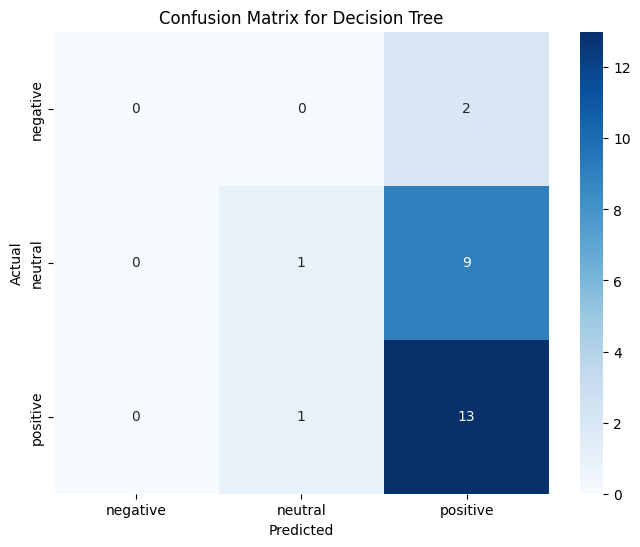

In [31]:
# Select best model based on F1-Score
best_model_name = results_df.iloc[0]['Model']
best_model_type = models[best_model_name]

# Retrain on training data
best_model = best_model_type.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
print(f"Best Model: {best_model_name}")
print(f"F1-Score (CV Mean): {results_df.iloc[0]['F1-Score Mean']:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Feature Analysis: Top Predictive Words and Word Clouds
To interpret the sentiment model, we analyze the most predictive words for each sentiment class and visualize them using word clouds. This helps understand which terms drive the model's decisions.

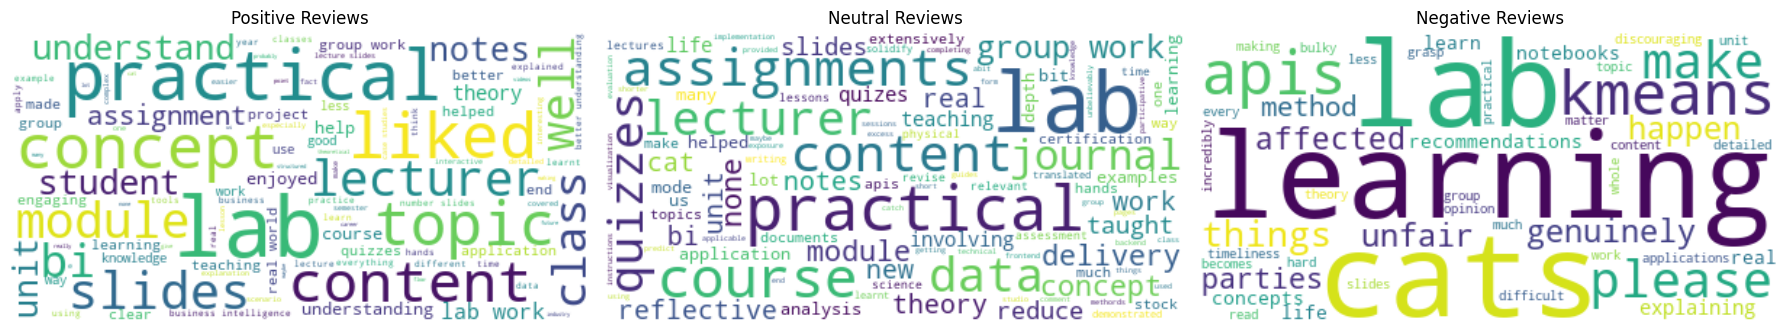

In [33]:
import numpy as np
from wordcloud import WordCloud

# Top predictive words per class
if hasattr(best_model, 'coef_'):
    print("Top Predictive Words per Sentiment Class:")
    for i, class_name in enumerate(best_model.classes_):
        top10 = np.argsort(best_model.coef_[i])[-10:]
        words = tfidf.get_feature_names_out()[top10]
        print(f"{class_name.upper()}: {', '.join(words)}")

# Word clouds by sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, sentiment in enumerate(['positive', 'neutral', 'negative']):
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"{sentiment.capitalize()} Reviews")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

### Export Trained Models and Vectorizers

To ensure reproducibility and enable future predictions, we export the trained models and vectorizers to the `model/` folder. This includes:

- LDA topic model (`lda`)
- CountVectorizer for topic modeling (`vectorizer`)
- Best sentiment classifier (`best_model`)
- TfidfVectorizer for sentiment modeling (`tfidf`)

These files can be loaded later for inference or further analysis without retraining.

In [34]:
# Export models and vectorizers to the model/ folder
import joblib
import os

os.makedirs('model', exist_ok=True)

# Export LDA topic model
joblib.dump(lda, 'model/lda_topic_model.joblib')

# Export CountVectorizer for topic modeling
joblib.dump(vectorizer, 'model/topic_vectorizer.joblib')

# Export best sentiment classifier
joblib.dump(best_model, 'model/sentiment_best_model.joblib')

# Export TfidfVectorizer for sentiment modeling
joblib.dump(tfidf, 'model/sentiment_tfidf_vectorizer.joblib')

print("Models and vectorizers exported to the model/ folder.")

Models and vectorizers exported to the model/ folder.


## Interpretation of Results and Recommendations

### Interpretation

**Discovered Topics:**
- Topic modeling revealed several key themes in student evaluations, including positive course experiences, suggestions for improvement, teaching methods, course content, and feedback/assessment.
- An overwhelming number of reviews clustered around positive engagement and teaching methods, indicating that students value interactive and well-structured learning environments.
- Suggestions for improvement and challenges were also featured, highlighting areas where students felt the course could be enhanced.

**Sentiment Distribution:**
- The majority of evaluations expressed positive sentiment, especially in topics related to course experience and teaching methods.
- Neutral and negative sentiments were more common in topics about challenges, feedback, and recommendations, suggesting that students use these as channels to voice concerns or constructive criticism.
- The sentiment analysis aligns with the topics, showing that positive feedback dominates in areas where students feel supported, while negative/neutral feedback is linked to requests for improvement.

### Recommendations

1. **Leverage Strengths:**
   - Continue to use interactive teaching methods and maintain a well-structured course format, as these are highly valued by students.
2. **Address Common Challenges:**
   - Review the most frequent suggestions and challenges to identify actionable improvements, such as providing more real-world examples or clearer feedback on assignments (these were the most-frequently occurring challenges).
3. **Enhance Feedback Mechanisms:**
   - Consider implementing additional support or resources for topics where negative or neutral sentiment is more prevalent, especially around assessments and feedback.
4. **Monitor Trends:**
   - Use the deployed interface to regularly analyze new evaluations, allowing for timely identification of emerging issues and strengths.

### Data Limitations and Model Implications

While the majority of student evaluations show positive sentiment, this may reflect a tendency for students to avoid voicing negative opinions, possibly due to social or institutional pressures. As a result, the dataset is imbalanced, with fewer negative reviews available for analysis.

This imbalance can limit the model's ability to accurately learn from and classify negative feedback. In future deployments, this could lead to misclassifications or underrepresentation of genuine concerns. For more robust insights, it is recommended to encourage honest and constructive feedback from students, ensuring that all perspectives are captured and the model can learn from a more representative sample.